In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
sns.set()

%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from vis_funcs import get_corr_empty_info
from data_prep.corrections import correct_macro_df

pd.options.mode.chained_assignment = None # default='warn'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
# train_df = pd.read_csv("data/train.csv")

# macro_df = pd.read_csv("data/macro.csv")
# macro_df['date'] = pd.to_datetime(macro_df['timestamp'])

train_df = pd.read_csv("../data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("../data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("../data/macro.csv", parse_dates=['timestamp'])

macro_df = correct_macro_df(macro_df=macro_df)

# train_df = pd.merge(train_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
# test_df = pd.merge(test_df, macro_df, how='left', on='timestamp', suffixes=['macro_',''])
# print(train_df.shape, test_df.shape)

# truncate the extreme values in price_doc #
# ulimit = np.percentile(train_df.price_doc.values, 99)
# llimit = np.percentile(train_df.price_doc.values, 1)
# train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
# train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

y_price = train_df.price_doc
del train_df["price_doc"]

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



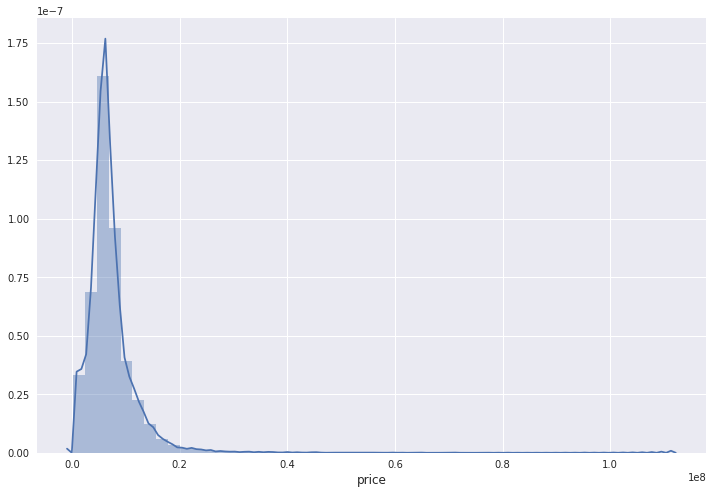

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



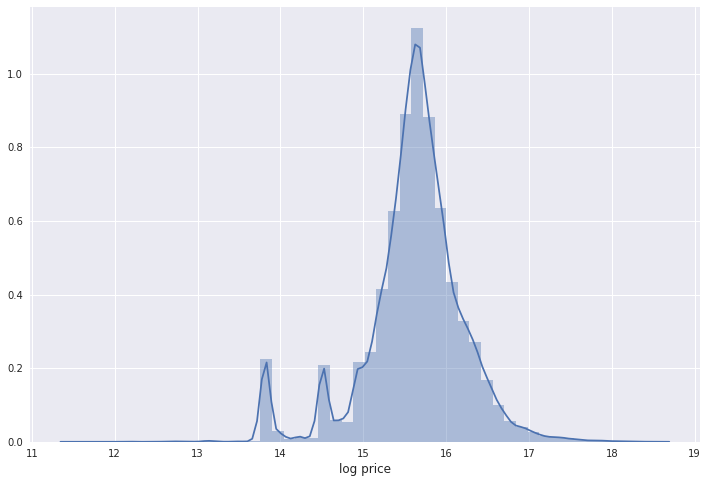

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(y_price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(y_price.values), bins=50, kde=True)
plt.xlabel('log price', fontsize=12)
plt.show()

Text(0.5,0,'% missing')

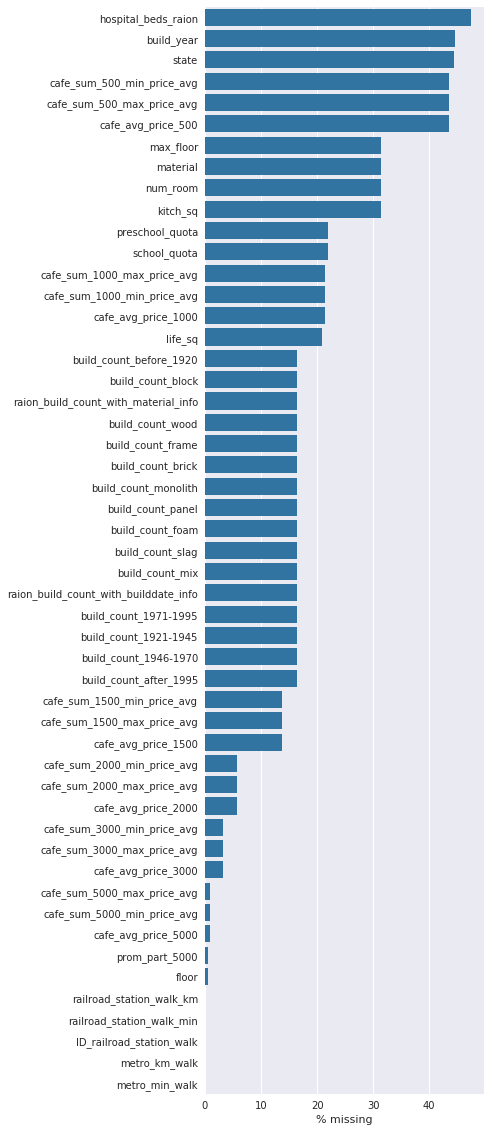

In [4]:
fig = plt.figure(figsize=(5,20))
train_na = (train_df.isnull().sum() / len(train_df)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
sns.barplot(y=train_na.index, x=train_na, color=color[0])
plt.xlabel('% missing')

In [5]:
def create_custom_columns(df):
    df = df.copy()
    df["build_count_before_1945"] = df["build_count_before_1920"] + df["build_count_1921-1945"]
    df["build_count_wood_slag"] = df['build_count_wood'] + df['build_count_slag']
    df['female_male_diff'] = df['female_f'] - df['male_f']
    df['young_female_male_diff'] = df['young_female'] - df['young_male']
    df["edu_culture_service_km"] = df["kindergarten_km"] + df["preschool_km"] + \
        df["school_km"] + df["university_km"] + df["additional_education_km"] + \
        df["museum_km"] + df["exhibition_km"] + df["theater_km"]
    df["energy_industry_km"] = df['incineration_km'] + df['nuclear_reactor_km'] + \
        df['radiation_km'] + df['power_transmission_line_km'] + df['thermal_power_plant_km']
    df["fitness_service_km"] = df['fitness_km'] + df['swim_pool_km'] + \
        df['ice_rink_km'] + df['stadium_km'] + df['basketball_km']
    df['school_preschool_raion'] = df['preschool_education_centers_raion'] + \
        df['school_education_centers_raion']
    return df[sorted(df.columns.tolist())]

def categorize_column(df, column_to_cat, lblencoder, drop_first_binary_feature=False):
    df = df.copy()
    cat_df = pd.DataFrame(lblencoder.transform(df[column_to_cat].astype(str)))
    cat_df_cols = [column_to_cat + "_" + c for c in lblencoder.classes_]
    if cat_df.shape[1]==1:
        cat_df_cols = cat_df_cols[0]
        cat_df.columns = [cat_df_cols]
    else:
        cat_df.columns = cat_df_cols
    
    if drop_first_binary_feature:
        del cat_df[column_to_cat + "_" + lbl.classes_[0]]
        cat_df_cols = cat_df_cols[1:]
    del df[column_to_cat]
    return pd.concat([df, cat_df], axis=1), cat_df_cols

def prepare_choosed_features(train_df, cols, test_df=None, dont_touch_cols=[]):
    new_cols = []
    for col in cols:
        print("Processing column:", col)
        if col in dont_touch_cols:
            new_cols.append(col)
        else:
            if is_string_dtype(train_df[col]):
                lbl = preprocessing.LabelBinarizer()
                lbl.fit(train_df[col])
                train_df, cat_columns = categorize_column(df=train_df, column_to_cat=col, lblencoder=lbl)
                new_cols += [cat_columns] if type(cat_columns)==str else cat_columns
                if test_df is not None:
                    test_df, test_cat_columns = categorize_column(df=test_df, column_to_cat=col, lblencoder=lbl)
            else:
                new_cols.append(col)
                if train_df[col].isnull().any():
                    train_df[col] = train_df[col].fillna(train_df[col].median())
    if test_df is not None:
        return train_df[new_cols], test_df[new_cols]
    else:
        return train_df[new_cols]

def manual_processing(df):
    df = df.copy()
    
#     df["material0"] = df.material.isnull().astype(int)
    df["material1"] = (df.material==1).astype(int)
    df["material2"] = (df.material==2).astype(int)
    df["material3"] = (df.material==3).astype(int)
    df["material4"] = (df.material==4).astype(int)
    df["material5"] = (df.material==5).astype(int)
    df["material6"] = (df.material==6).astype(int)
    del df["material"]
    
    df["build0"] = (df.build_year==0).astype(int)
    df["build1"] = (df.build_year==1).astype(int)
    df.loc[df.build_year>2030,"build_year"] = np.NaN
    df.loc[df.build_year<1600,"build_year"] = np.NaN
    df["nobuild"] = df.build_year.isnull().astype(int)
    df["transaction_since_build"] = pd.to_datetime(df.timestamp).dt.year - df.build_year
    df.build_year = df.build_year.fillna(df.build_year.mode().values[0])
    df.transaction_since_build = df.transaction_since_build.fillna(df.transaction_since_build.median())
    
    df["floor0"] = (df.floor==0).astype(int)
    df["floor1"] = (df.floor==1).astype(int)
    df["floorhuge"] = (df.floor>40).astype(int)
#    df["lnfloor"] = np.log(df.floor+1)

    df["nomax_floor"] = df.max_floor.isnull().astype(int)
    df.max_floor = df.max_floor.fillna(df.max_floor.median())
    df["max0"] = (df.max_floor==0).astype(int)
    df["max1"] = (df.max_floor==1).astype(int)
    df["maxhuge"] = (df.max_floor>80).astype(int)
#    df["lnmax"] = np.log(df.max_floor+1)
    
    return df

In [6]:
train_df = create_custom_columns(train_df)
test_df = create_custom_columns(test_df)

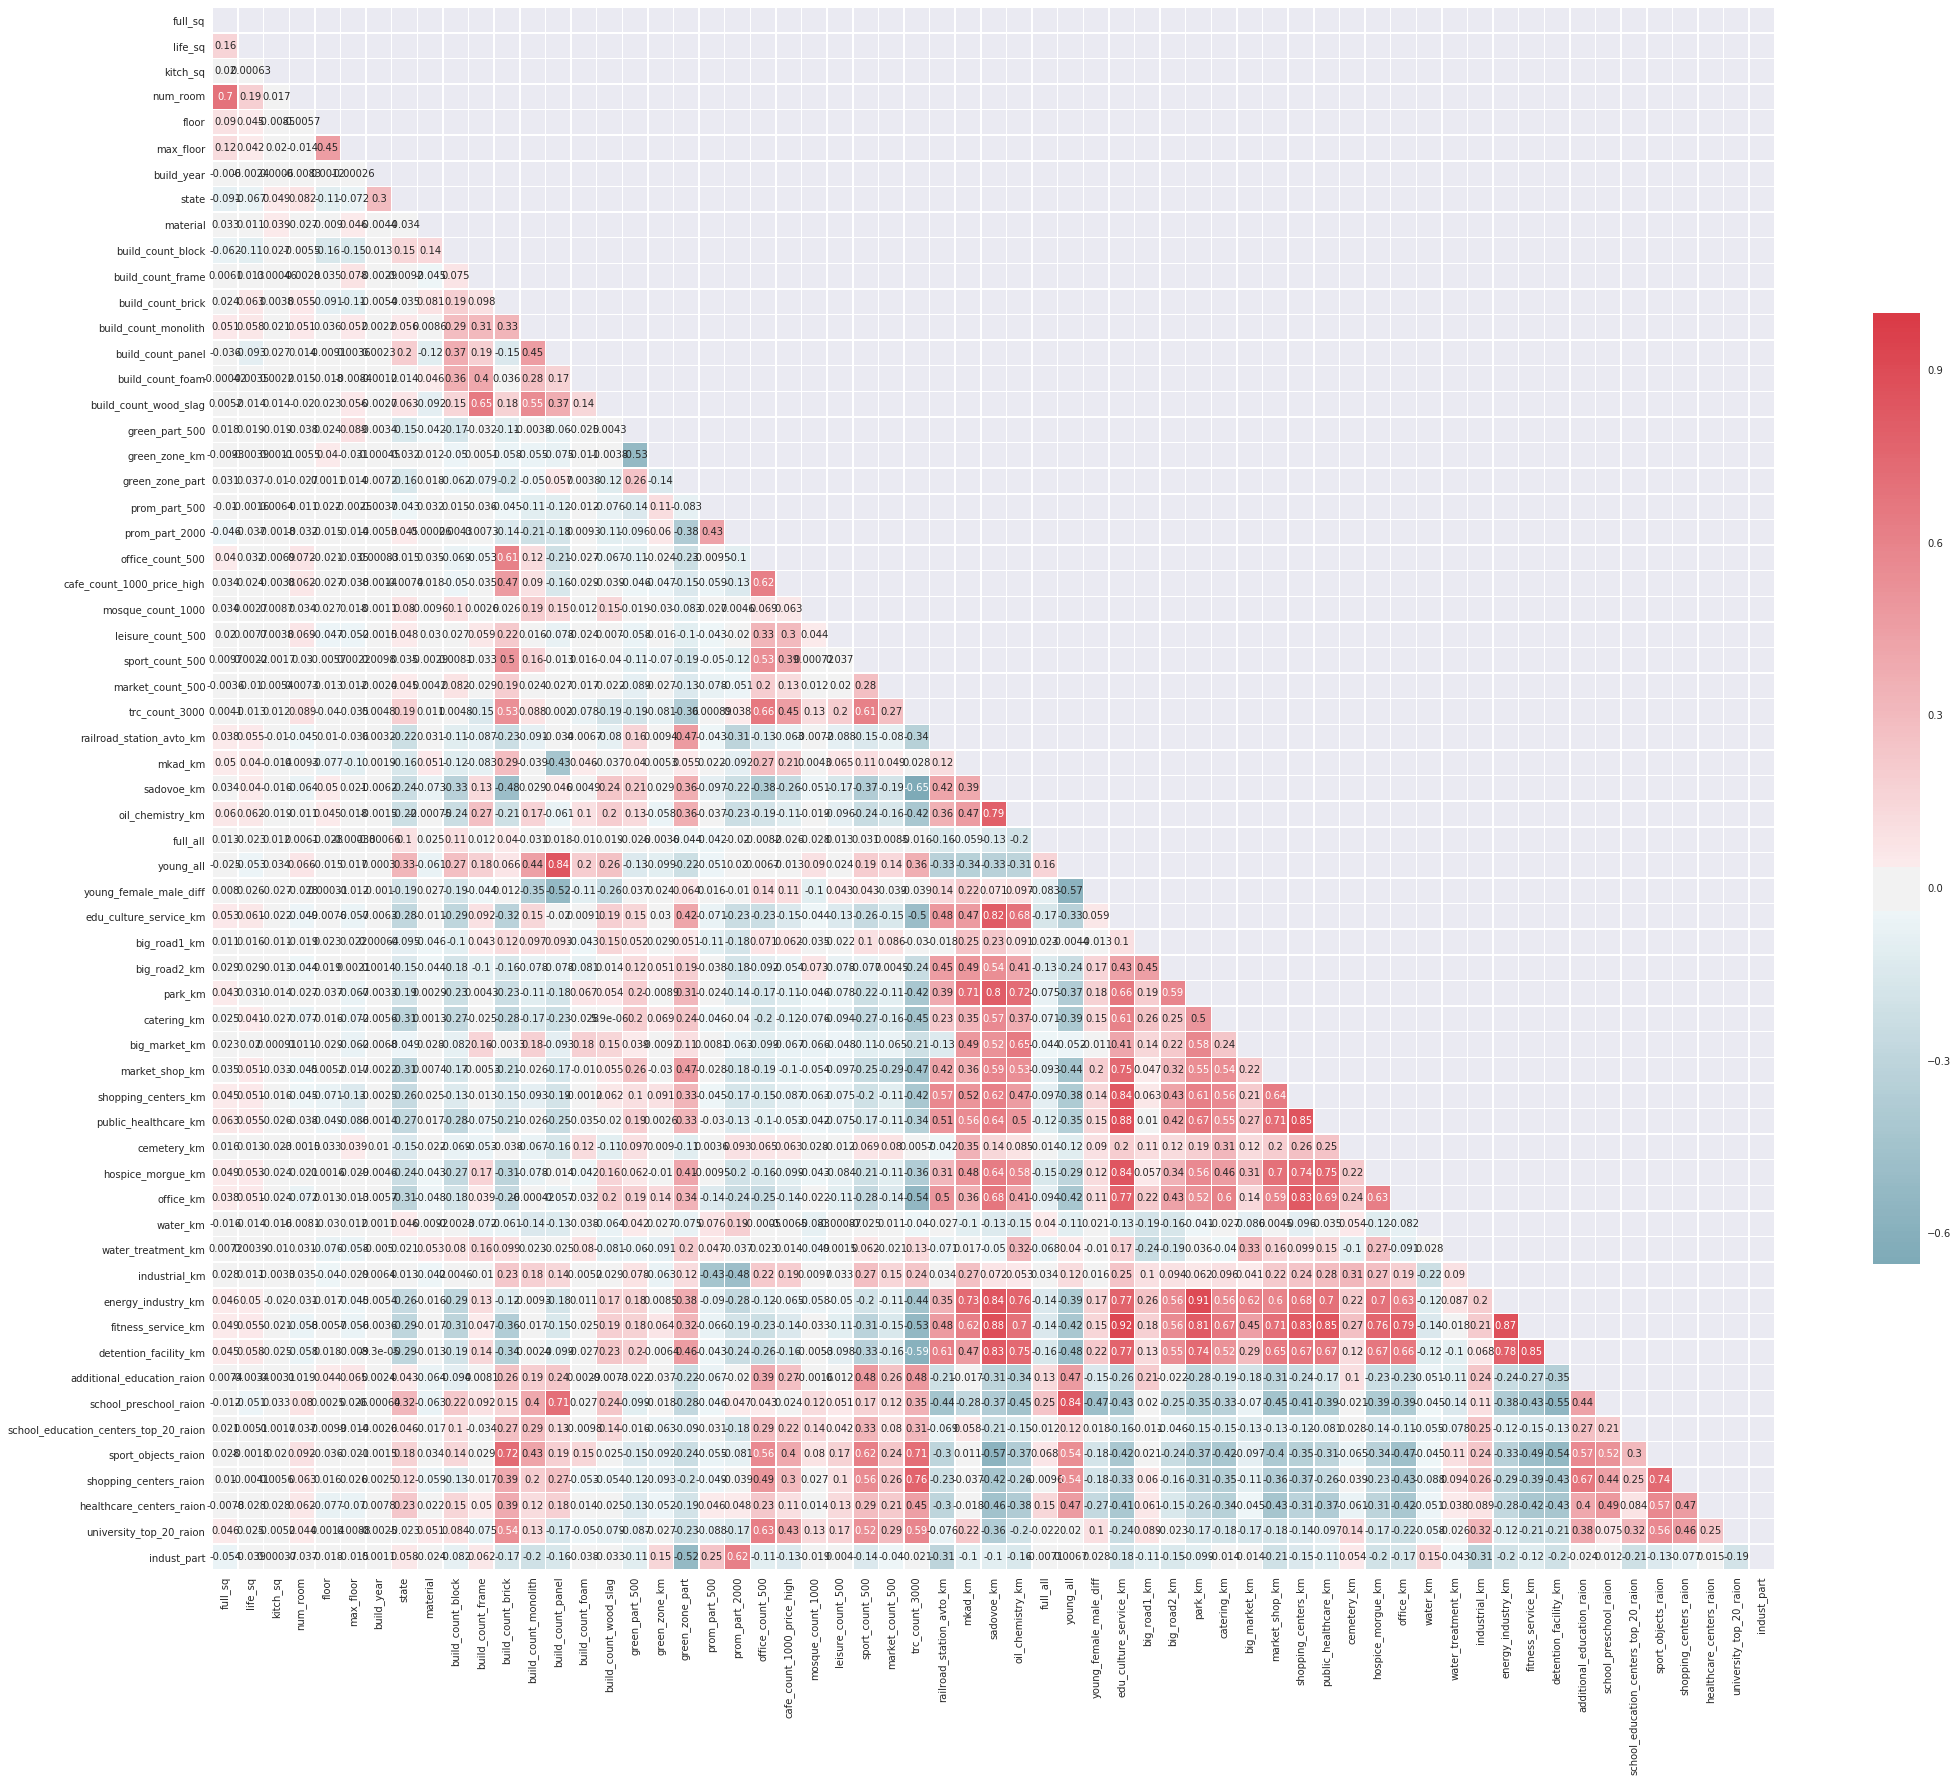

In [8]:
cols = [
    'timestamp',
    'full_sq',
    'life_sq',
    'kitch_sq',
    'num_room',
    'floor',
    'max_floor',
    'build_year',
    'product_type',
    'state',
    'material',
    'sub_area',
    'build_count_block',
    'build_count_frame',
    'build_count_brick',
    'build_count_monolith',
    'build_count_panel',
    'build_count_foam',
    'build_count_wood_slag',
    'green_part_500',
    'green_zone_km',
    'green_zone_part',
    'prom_part_500',
    'prom_part_2000',
    'office_count_500',
    'cafe_count_1000_price_high',
    'mosque_count_1000',
    'leisure_count_500',
    'sport_count_500',
    'market_count_500',
    'trc_count_3000',
    'railroad_station_avto_km',
    'mkad_km',
    'sadovoe_km',
    'oil_chemistry_km',
    'full_all',
    'young_all',
    'young_female_male_diff',
    'edu_culture_service_km',
    'big_road1_km',
    'big_road2_km',
    'park_km',
    'catering_km',
    'big_market_km',
    'market_shop_km',
    'shopping_centers_km',
    'public_healthcare_km',
    'cemetery_km',
    'hospice_morgue_km',
    'office_km',
    'water_km',
    'water_treatment_km',
    'industrial_km',
    'energy_industry_km',
    'fitness_service_km',
    'detention_facility_km',
    'additional_education_raion',
    'thermal_power_plant_raion',
    'big_market_raion',
    'railroad_terminal_raion',
    'school_preschool_raion',
    'school_education_centers_top_20_raion',
    'incineration_raion',
    'radiation_raion',
    'sport_objects_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
    'oil_chemistry_raion',
    'shopping_centers_raion',
    'healthcare_centers_raion',
    'university_top_20_raion',
    'indust_part'
]

cdf = train_df[cols].sort_index()
corr_df = cdf.corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(35, 35))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [9]:
train_df[cols].dtypes

timestamp                                datetime64[ns]
full_sq                                           int64
life_sq                                         float64
kitch_sq                                        float64
num_room                                        float64
floor                                           float64
max_floor                                       float64
build_year                                      float64
product_type                                     object
state                                           float64
material                                        float64
sub_area                                         object
build_count_block                               float64
build_count_frame                               float64
build_count_brick                               float64
build_count_monolith                            float64
build_count_panel                               float64
build_count_foam                                

---

In [15]:
seen_cols = []

In [16]:
USE_FEATURES = [
    "full_sq", "life_sq", "kitch_sq", "num_room",
    "floor", "max_floor", 
    "build_year", "timestamp",
    "product_type", "state", "material", 
    "sub_area",
]

In [17]:
seen_cols += USE_FEATURES

##########################################################
                  prct_non_empty        col_type
full_sq                      1.0           int64
life_sq       0.7905221358012536         float64
kitch_sq      0.6858652489252076         float64
num_room      0.6858652489252076         float64
floor         0.9945193790817498         float64
max_floor     0.6858652489252076         float64
build_year    0.5535098946539333         float64
timestamp                    1.0  datetime64[ns]
product_type                 1.0          object
state         0.5550195267631518         float64
material      0.6858652489252076         float64
sub_area                     1.0          object
##########################################################


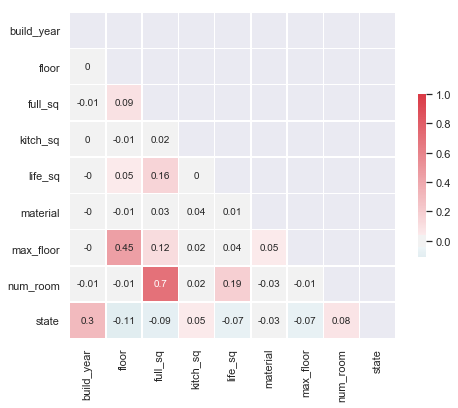

In [18]:
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=USE_FEATURES)

##########################################################
                           prct_non_empty col_type
build_count_block      0.8362049161497818  float64
build_count_frame      0.8362049161497818  float64
build_count_brick      0.8362049161497818  float64
build_count_monolith   0.8362049161497818  float64
build_count_panel      0.8362049161497818  float64
build_count_foam       0.8362049161497818  float64
build_count_wood_slag  0.8362049161497818  float64
##########################################################


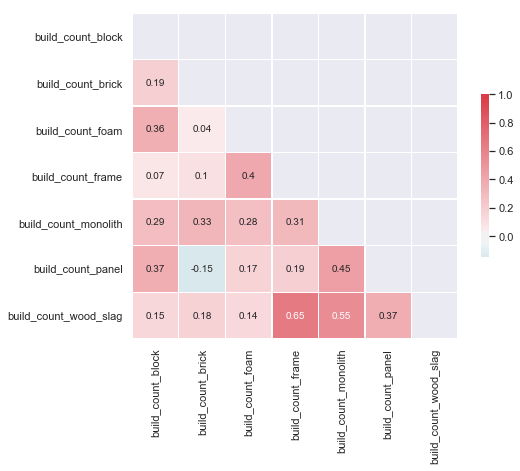

In [19]:
cols = [
#     'raion_build_count_with_material_info',
#     'raion_build_count_with_builddate_info',
#     'build_count_wood',
#     'build_count_slag',
    'build_count_block',
    'build_count_frame',
    'build_count_brick',
    'build_count_monolith',
    'build_count_panel',
    'build_count_foam',
    "build_count_wood_slag",
#     'build_count_mix',
#     'build_count_before_1920',
#     'build_count_1921-1945',
#     "build_count_before_1945",
#     'build_count_1946-1970',
#     'build_count_1971-1995',
#     'build_count_after_1995'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [20]:
cols_to_add = [
    'raion_build_count_with_material_info',
    'raion_build_count_with_builddate_info',
    'build_count_wood',
    'build_count_slag',
    'build_count_block',
    'build_count_frame',
    'build_count_brick',
    'build_count_monolith',
    'build_count_panel',
    'build_count_foam',
    "build_count_wood_slag",
    'build_count_mix',
    'build_count_before_1920',
    'build_count_1921-1945',
    "build_count_before_1945",
    'build_count_1946-1970',
    'build_count_1971-1995',
    'build_count_after_1995'
]
seen_cols += cols_to_add

In [21]:
USE_FEATURES += cols

##########################################################
                prct_non_empty col_type
green_part_500             1.0  float64
green_zone_km              1.0  float64
green_zone_part            1.0  float64
prom_part_500              1.0  float64
prom_part_2000             1.0  float64
##########################################################


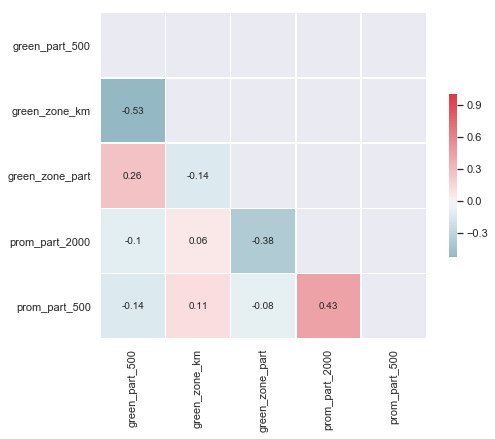

In [22]:
cols = [
    'green_part_500',
    'green_zone_km',
    'green_zone_part',
    'prom_part_500',
#     'green_part_1000',
#     'prom_part_1000',
#     'green_part_1500',
#     'prom_part_1500',
#     'green_part_2000',
    'prom_part_2000',
#     'green_part_3000',
#     'prom_part_3000',
#     'green_part_5000',
#     'prom_part_5000'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [23]:
cols_to_add = [
    'green_part_500',
    'green_zone_km',
    'green_zone_part',
    'prom_part_500',
    'green_part_1000',
    'prom_part_1000',
    'green_part_1500',
    'prom_part_1500',
    'green_part_2000',
    'prom_part_2000',
    'green_part_3000',
    'prom_part_3000',
    'green_part_5000',
    'prom_part_5000'
]
seen_cols += cols_to_add

In [24]:
USE_FEATURES += cols

##########################################################
                           prct_non_empty col_type
office_count_500                      1.0    int64
cafe_count_1000_price_high            1.0    int64
mosque_count_1000                     1.0    int64
leisure_count_500                     1.0    int64
sport_count_500                       1.0    int64
market_count_500                      1.0    int64
trc_count_3000                        1.0    int64
railroad_station_avto_km              1.0  float64
mkad_km                               1.0  float64
sadovoe_km                            1.0  float64
oil_chemistry_km                      1.0  float64
full_all                              1.0    int64
young_all                             1.0    int64
young_female_male_diff                1.0    int64
##########################################################


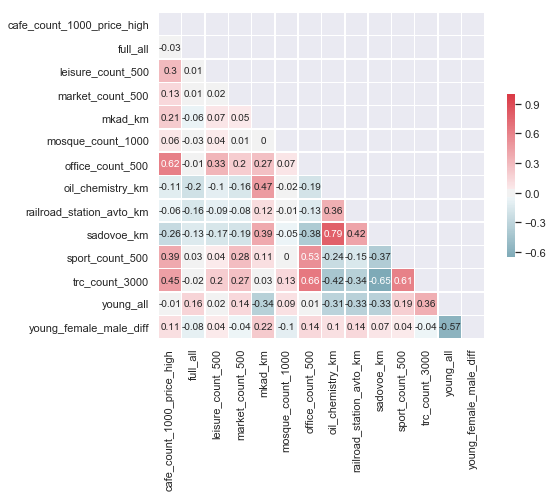

In [25]:
cols = [
    'office_count_500',
#     'trc_count_500',
#     'cafe_count_500',
#     'cafe_count_500_na_price',
#     'cafe_count_500_price_500',
#     'cafe_count_500_price_1000',
#     'cafe_count_500_price_1500',
#     'cafe_count_500_price_2500',
#     'cafe_count_500_price_4000',
    'cafe_count_1000_price_high',
#     'big_church_count_500',
#     'church_count_500',
    'mosque_count_1000',
    'leisure_count_500',
    'sport_count_500',
    'market_count_500',
    'trc_count_3000',
#     'cafe_count_1500_price_high',
#     'metro_km_walk',
    'railroad_station_avto_km',
#     'railroad_km',
#     'railroad_station_avto_min',
#     'zd_vokzaly_avto_km',
#     'bus_terminal_avto_km',
    'mkad_km',
#     'ttk_km',
    'sadovoe_km',
#     'ts_km',
    'oil_chemistry_km',
#     'kremlin_km',
    'full_all',
#     'female_male_diff'
    'young_all',
    'young_female_male_diff',
#     'work_all', 'work_male', 'work_female'
#     'ekder_all',
#     'ekder_male', 'ekder_female',
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [26]:
cols_to_add = [
    'office_count_500',
    'trc_count_500',
    'cafe_count_500',
    'cafe_count_500_na_price',
    'cafe_count_500_price_500',
    'cafe_count_500_price_1000',
    'cafe_count_500_price_1500',
    'cafe_count_500_price_2500',
    'cafe_count_500_price_4000',
    'cafe_count_1000_price_high',
    'big_church_count_500',
    'church_count_500',
    'mosque_count_1000',
    'leisure_count_500',
    'sport_count_500',
    'market_count_500',
    'trc_count_3000',
    'cafe_count_1500_price_high',
    'metro_km_walk',
    'railroad_station_avto_km',
    'railroad_km',
    'railroad_station_avto_min',
    'zd_vokzaly_avto_km',
    'bus_terminal_avto_km',
    'mkad_km',
    'ttk_km',
    'sadovoe_km',
    'ts_km',
    'oil_chemistry_raion',
    'oil_chemistry_km',
    'kremlin_km',
    'full_all',
    'female_male_diff'
    'young_all',
    'young_female_male_diff',
    'work_all', 'work_male', 'work_female'
    'ekder_all',
    'ekder_male', 'ekder_female',
]
seen_cols += cols_to_add

In [27]:
USE_FEATURES += cols

##########################################################
                       prct_non_empty col_type
edu_culture_service_km            1.0  float64
big_road1_km                      1.0  float64
big_road2_km                      1.0  float64
park_km                           1.0  float64
catering_km                       1.0  float64
big_market_km                     1.0  float64
market_shop_km                    1.0  float64
shopping_centers_km               1.0  float64
public_healthcare_km              1.0  float64
cemetery_km                       1.0  float64
hospice_morgue_km                 1.0  float64
office_km                         1.0  float64
water_km                          1.0  float64
water_treatment_km                1.0  float64
industrial_km                     1.0  float64
energy_industry_km                1.0  float64
fitness_service_km                1.0  float64
detention_facility_km             1.0  float64
################################################

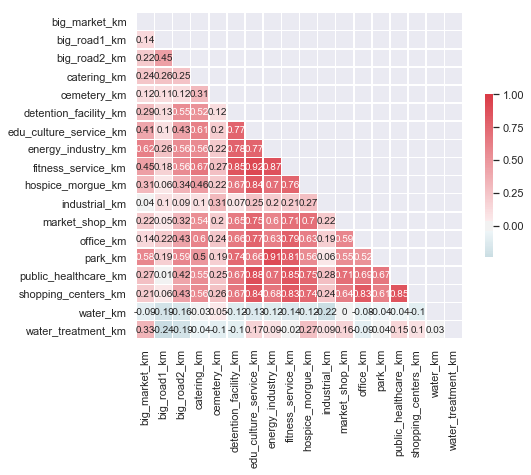

In [28]:
cols = [
#     'preschool_km',
#     'kindergarten_km',
#     'school_km',
#     'university_km',
#     'additional_education_km',
#     'theater_km',
#     'museum_km',
#     'exhibition_km',
    
    'edu_culture_service_km',
    
    'big_road1_km',
    'big_road2_km',
    
    'park_km',
    'catering_km',
    'big_market_km',
    'market_shop_km',
    'shopping_centers_km',
    
    'public_healthcare_km',
    'cemetery_km',
    'hospice_morgue_km',
    
    'office_km',
    'water_km',
    'water_treatment_km',
    
    'industrial_km',
    
#     'incineration_km',
#     'nuclear_reactor_km',
#     'radiation_km',
#     'power_transmission_line_km',
#     'thermal_power_plant_km',
    
    'energy_industry_km',
    
#     'fitness_km',
#     'swim_pool_km',
#     'ice_rink_km',
#     'stadium_km',
#     'basketball_km',
    
    'fitness_service_km',
    
    'detention_facility_km',
    
#     'workplaces_km',
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=cols)

In [29]:
cols_to_add = [
    'preschool_km',
    'kindergarten_km',
    'school_km',
    'university_km',
    'additional_education_km',
    'theater_km',
    'museum_km',
    'exhibition_km',
    'edu_culture_service_km',
    'big_road1_km',
    'big_road2_km',
    'park_km',
    'catering_km',
    'big_market_km',
    'market_shop_km',
    'shopping_centers_km',
    'public_healthcare_km',
    'cemetery_km',
    'hospice_morgue_km',
    'office_km',
    'water_km',
    'water_treatment_km',
    'industrial_km',
    'incineration_km',
    'nuclear_reactor_km',
    'radiation_km',
    'power_transmission_line_km',
    'thermal_power_plant_km',
    'energy_industry_km',
    'fitness_km',
    'swim_pool_km',
    'ice_rink_km',
    'stadium_km',
    'basketball_km',
    'fitness_service_km',
    'detention_facility_km',
    'workplaces_km',
]
seen_cols += cols_to_add

In [30]:
USE_FEATURES += cols

##########################################################
                                      prct_non_empty col_type
additional_education_raion                       1.0    int64
thermal_power_plant_raion                        1.0   object
big_market_raion                                 1.0   object
railroad_terminal_raion                          1.0   object
school_preschool_raion                           1.0    int64
school_education_centers_top_20_raion            1.0    int64
incineration_raion                               1.0   object
radiation_raion                                  1.0   object
sport_objects_raion                              1.0    int64
nuclear_reactor_raion                            1.0   object
detention_facility_raion                         1.0   object
oil_chemistry_raion                              1.0   object
shopping_centers_raion                           1.0    int64
healthcare_centers_raion                         1.0    int64
university_

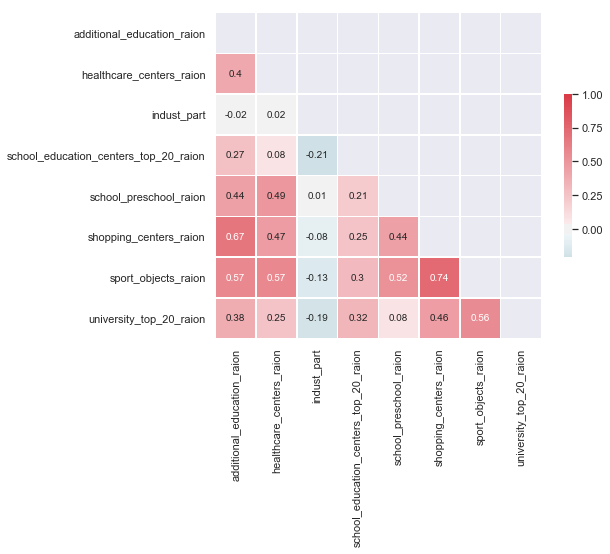

In [31]:
raion_cols = [
    'additional_education_raion',
#     'culture_objects_top_25_raion',
    'thermal_power_plant_raion',
    'big_market_raion',
    'railroad_terminal_raion',
    
#     'preschool_education_centers_raion',
#     'school_education_centers_raion',
    'school_preschool_raion',
    
    'school_education_centers_top_20_raion',
    
    'incineration_raion',
    'radiation_raion',
    'sport_objects_raion',
#     'hospital_beds_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
#     'office_raion',
    'oil_chemistry_raion',
    'shopping_centers_raion',
    'healthcare_centers_raion',
    'university_top_20_raion',
    'indust_part'
]
corr_df, empty_info = get_corr_empty_info(df=train_df, cols=raion_cols)

In [32]:
USE_FEATURES += raion_cols

In [33]:
seen_cols += list(filter(lambda x: "_raion" in x, train_df.columns)) + ['indust_part']

In [35]:
len(USE_FEATURES)

72

Text(0.5, 0, '% missing')

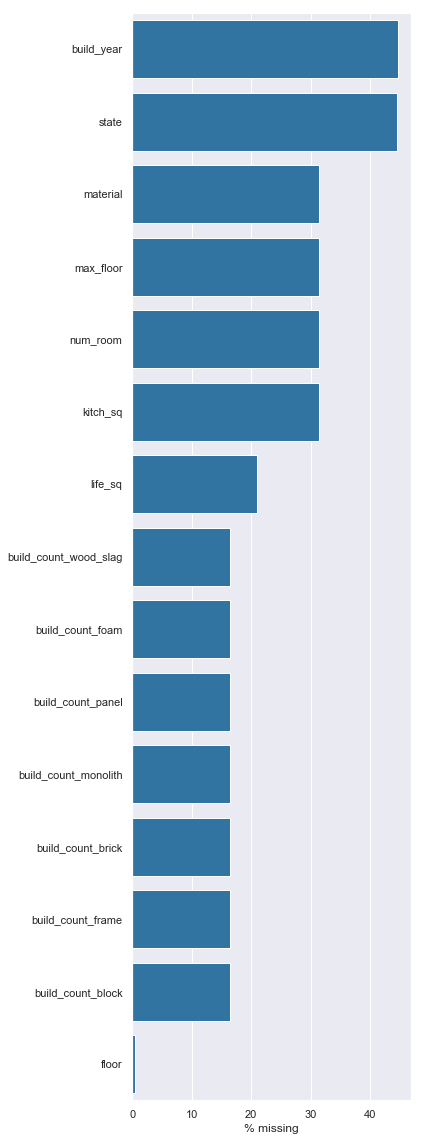

In [26]:
fig = plt.figure(figsize=(5,20))
train_na = (train_df[USE_FEATURES].isnull().sum() / len(train_df[USE_FEATURES])) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
sns.barplot(y=train_na.index, x=train_na, color=color[0])
plt.xlabel('% missing')

In [27]:
check_cols = sorted(list(set(train_df.columns) - set(seen_cols)))
check_cols

['0_13_all',
 '0_13_female',
 '0_13_male',
 '0_17_all',
 '0_17_female',
 '0_17_male',
 '0_6_all',
 '0_6_female',
 '0_6_male',
 '16_29_all',
 '16_29_female',
 '16_29_male',
 '7_14_all',
 '7_14_female',
 '7_14_male',
 'ID_big_road1',
 'ID_big_road2',
 'ID_bus_terminal',
 'ID_metro',
 'ID_railroad_station_avto',
 'ID_railroad_station_walk',
 'ID_railroad_terminal',
 'area_m',
 'big_church_count_1000',
 'big_church_count_1500',
 'big_church_count_2000',
 'big_church_count_3000',
 'big_church_count_5000',
 'big_church_km',
 'big_road1_1line',
 'bulvar_ring_km',
 'cafe_avg_price_1000',
 'cafe_avg_price_1500',
 'cafe_avg_price_2000',
 'cafe_avg_price_3000',
 'cafe_avg_price_500',
 'cafe_avg_price_5000',
 'cafe_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_500',
 'cafe_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_1000',
 'cafe_coun

In [28]:
train_df_processed, test_df_processed = prepare_choosed_features(
    train_df, USE_FEATURES, test_df=test_df, dont_touch_cols=["build_year", "timestamp", "material", "max_floor"])

Processing column: full_sq
Processing column: life_sq
Processing column: kitch_sq
Processing column: num_room
Processing column: floor
Processing column: max_floor
Processing column: build_year
Processing column: timestamp
Processing column: product_type
Processing column: state
Processing column: material
Processing column: sub_area
Processing column: build_count_block
Processing column: build_count_frame
Processing column: build_count_brick
Processing column: build_count_monolith
Processing column: build_count_panel
Processing column: build_count_foam
Processing column: build_count_wood_slag
Processing column: green_part_500
Processing column: green_zone_km
Processing column: green_zone_part
Processing column: prom_part_500
Processing column: prom_part_2000
Processing column: office_count_500
Processing column: cafe_count_1000_price_high
Processing column: mosque_count_1000
Processing column: leisure_count_500
Processing column: sport_count_500
Processing column: market_count_500
Pro

In [29]:
train_df_processed = manual_processing(train_df_processed)
test_df_processed = manual_processing(test_df_processed)

In [31]:
# train_df_processed.corr().to_excel("use_features_corr.xlsx")

In [52]:
train_df_processed_corr = train_df_processed.corr()
print(train_df_processed_corr.shape)
train_df_processed_corr = train_df_processed_corr.where(
    ~np.triu(np.ones(train_df_processed_corr.shape)).astype(np.bool)).stack().reset_index()
train_df_processed_corr.columns = ["feature1", "feature2", "corr_value"]

(233, 233)


In [60]:
train_df_processed_corr[train_df_processed_corr["corr_value"].abs()>0.8]

,feature1,feature2,corr_value
12759,build_count_foam,sub_area_Horoshevo-Mnevniki,0.974606
16466,edu_culture_service_km,sadovoe_km,0.815127
17012,park_km,sadovoe_km,0.802590
17759,shopping_centers_km,edu_culture_service_km,0.838454
17947,public_healthcare_km,edu_culture_service_km,0.877948
17954,public_healthcare_km,shopping_centers_km,0.852842
18326,hospice_morgue_km,edu_culture_service_km,0.840823
18524,office_km,shopping_centers_km,0.829544
19286,energy_industry_km,sadovoe_km,0.842727
19294,energy_industry_km,park_km,0.905111


In [63]:
macro_df_corr = macro_df.corr()
print(macro_df_corr.shape)
macro_df_corr = macro_df_corr.where(
    ~np.triu(np.ones(macro_df_corr.shape)).astype(np.bool)).stack().reset_index()
macro_df_corr.columns = ["feature1", "feature2", "corr_value"]

(99, 99)


##########################################################
                      prct_non_empty col_type
gdp_quart         0.9637681159420289  float64
gdp_quart_growth  0.9637681159420289  float64
micex             0.9959742351046699  float64
micex_cbi_tr       0.999597423510467  float64
usdrub             0.998792270531401  float64
mortgage_rate                    1.0  float64
deposits_rate     0.8333333333333334  float64
oil_urals                        1.0  float64
##########################################################


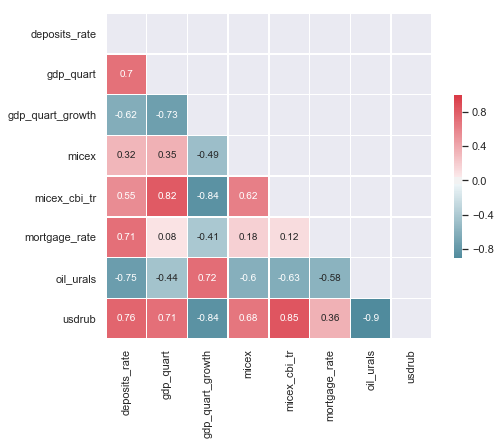

In [35]:
mcols = [
    "gdp_quart",
    'gdp_quart_growth',
    "micex",
    "micex_cbi_tr",
    "usdrub",
    "mortgage_rate",
    "deposits_rate",
    "oil_urals"
]

corr_df, empty_info = get_corr_empty_info(df=macro_df, cols=mcols)